In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [21]:
# load preprocessed bookings
bookings = pd.read_csv('/content/drive/MyDrive/SwiftTraq/Portfolio/012_RV_Van_Rentals_Analytics/data/bookings_full.csv', parse_dates=['pickup_date','dropoff_date'])

In [22]:
bookings.head()

,booking_id,booking_date,customer_id,camper_id,pickup_date,rental_days,dropoff_date,pickup_location,dropoff_location,booking_channel,...,signup_date,country,model,type,year,location_id,service_due,day_of_week,is_weekend,holiday_flag
0,BK00000,2024-01-04,CUST00536,RV00972,2024-01-08,12,2024-01-20,LOC015,LOC063,Walk-in,...,2020-06-22,Svalbard & Jan Mayen Islands,Name,Truck Camper,2013,LOC068,No,Monday,False,0
1,BK00001,2023-01-20,CUST31935,RV00830,2023-02-26,2,2023-02-28,LOC008,LOC043,Online,...,2023-09-20,Congo,Include,Class A,2010,LOC013,No,Sunday,True,0
2,BK00002,2024-07-01,CUST02200,RV00411,2024-08-10,13,2024-08-23,LOC006,LOC001,Online,...,2022-04-06,Venezuela,Table,Class B,2014,LOC057,No,Saturday,True,0
3,BK00003,2023-06-28,CUST43422,RV00812,2023-08-30,12,2023-09-11,LOC069,LOC013,Online,...,2022-11-20,Iran,Today,Class C,2020,LOC010,No,Wednesday,False,0
4,BK00004,2022-08-08,CUST48470,RV00043,2022-10-15,5,2022-10-20,LOC085,LOC010,App,...,2022-05-17,Cook Islands,Forget,Pop-Up,2016,LOC039,No,Saturday,True,0


In [23]:
bookings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   booking_id        50000 non-null  object        
 1   booking_date      50000 non-null  object        
 2   customer_id       50000 non-null  object        
 3   camper_id         50000 non-null  object        
 4   pickup_date       50000 non-null  datetime64[ns]
 5   rental_days       50000 non-null  int64         
 6   dropoff_date      50000 non-null  datetime64[ns]
 7   pickup_location   50000 non-null  object        
 8   dropoff_location  50000 non-null  object        
 9   booking_channel   50000 non-null  object        
 10  base_price        50000 non-null  int64         
 11  total_price       50000 non-null  int64         
 12  booking_status    50000 non-null  object        
 13  addons            50000 non-null  object        
 14  season            5000

##### -------------------------------
##### 🗓️ Aggregate Daily Demand
##### -------------------------------

In [24]:
daily_demand = bookings.groupby('pickup_date').size().reset_index(name='num_bookings')
daily_demand = daily_demand.sort_values('pickup_date')

# plot trend
fig = px.line(daily_demand, x='pickup_date', y='num_bookings')
fig.update_layout(xaxis_title='Date',
                  yaxis_title='Number of Bookings',
                  template='plotly_white')
fig.show()

##### -------------------------------
##### 🔮 Forecasting with Prophet
##### -------------------------------

In [25]:
daily_demand.head(3)

,pickup_date,num_bookings
0,2022-04-20,42
1,2022-04-21,63
2,2022-04-22,45


DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4hs_mcj/3sd3zue7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4hs_mcj/466unwpg.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65983', 'data', 'file=/tmp/tmpw4hs_mcj/3sd3zue7.json', 'init=/tmp/tmpw4hs_mcj/466unwpg.json', 'output', 'file=/tmp/tmpw4hs_mcj/prophet_model0w8s7krj/prophet_model-20250422214406.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:06 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:44:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


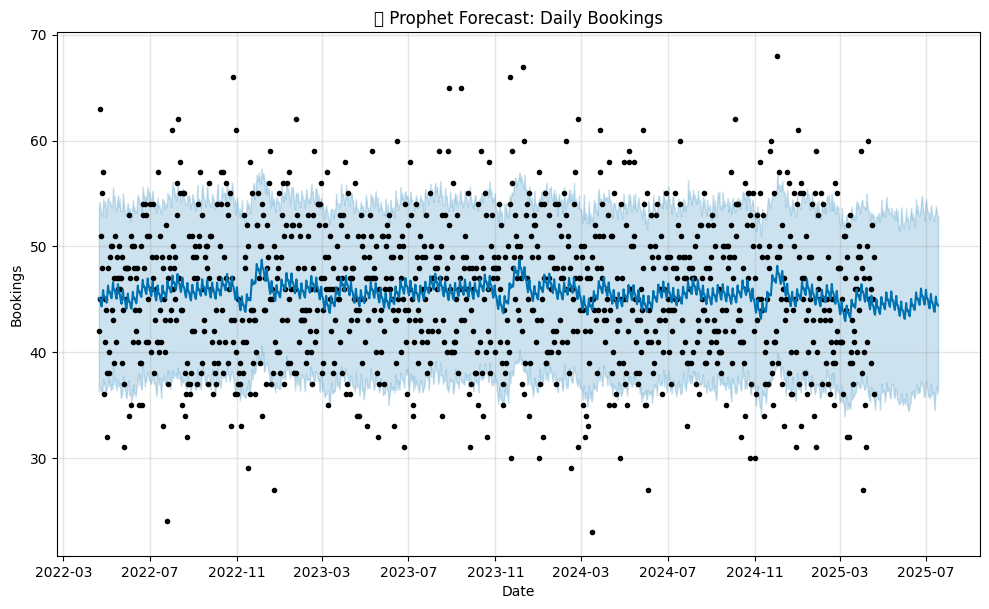

In [26]:
prophet_df = daily_demand.rename(columns={'pickup_date': 'ds', 'num_bookings': 'y'})
model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model.fit(prophet_df)
future = model.make_future_dataframe(periods=90)
forecast = model.predict(future)

fig = model.plot(forecast)
plt.title('📈 Prophet Forecast: Daily Bookings')
plt.xlabel('Date')
plt.ylabel('Bookings')
plt.show();

In [27]:
# prophet Evaluation
train = prophet_df[:-30]
test = prophet_df[-30:]
model_eval = Prophet(yearly_seasonality=True, weekly_seasonality=True)
model_eval.fit(train)
future_eval = model_eval.make_future_dataframe(periods=30)
forecast_eval = model_eval.predict(future_eval)
pred = forecast_eval[-30:]["yhat"].values
actual = test["y"].values
rmse_prophet = np.sqrt(mean_squared_error(actual, pred))
print(f"\n RMSE (Prophet): {rmse_prophet:.2f}")


INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4hs_mcj/7hhhzjwa.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpw4hs_mcj/ni3p2c2j.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41060', 'data', 'file=/tmp/tmpw4hs_mcj/7hhhzjwa.json', 'init=/tmp/tmpw4hs_mcj/ni3p2c2j.json', 'output', 'file=/tmp/tmpw4hs_mcj/prophet_modelyfbg56i5/prophet_model-20250422214407.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:44:07 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:44:07 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing



 RMSE (Prophet): 7.14


##### -------------------------------
##### 📉 SARIMAX Forecasting
##### -------------------------------

RMSE (SARIMAX): 7.09


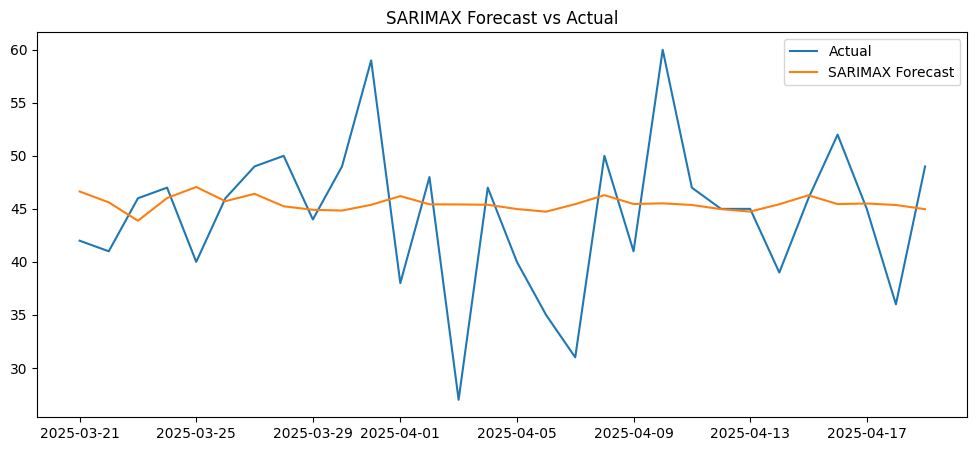

In [28]:
daily_demand.head()
demand_ts = daily_demand.set_index('pickup_date')['num_bookings']
train_ts, test_ts = demand_ts[:-30], demand_ts[-30:]

sarimax_model = SARIMAX(train_ts, order=(1,1,1), seasonal_order=(1,1,1,7))
sarimax_results = sarimax_model.fit()
sarimax_forecast = sarimax_results.predict(start=test_ts.index[0], end=test_ts.index[-1])
rmse_sarimax = np.sqrt(mean_squared_error(test_ts, sarimax_forecast))
print(f"RMSE (SARIMAX): {rmse_sarimax:.2f}")

plt.figure(figsize=(12, 5))
plt.plot(test_ts.index, test_ts.values, label='Actual')
plt.plot(test_ts.index, sarimax_forecast, label='SARIMAX Forecast')
plt.title('SARIMAX Forecast vs Actual')
plt.legend()
plt.show()

##### -------------------------------
##### ⚙️ XGBoost Forecasting
##### -------------------------------

In [29]:
df_xgb = daily_demand.copy()
df_xgb['dayofweek'] = df_xgb['pickup_date'].dt.dayofweek
df_xgb['month'] = df_xgb['pickup_date'].dt.month
df_xgb['lag1'] = df_xgb['num_bookings'].shift(1)
df_xgb['lag7'] = df_xgb['num_bookings'].shift(7)

features = ['dayofweek', 'month', 'lag1', 'lag7']
X = df_xgb[features]
y = df_xgb['num_bookings']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=30, shuffle=False)

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
rmse_xgb = np.sqrt(mean_squared_error(y_test, y_pred_xgb))
print(f"RMSE (XGBoost): {rmse_xgb:.2f}")

RMSE (XGBoost): 6.86


##### -------------------------------
##### 📊 Compare All Models
##### -------------------------------

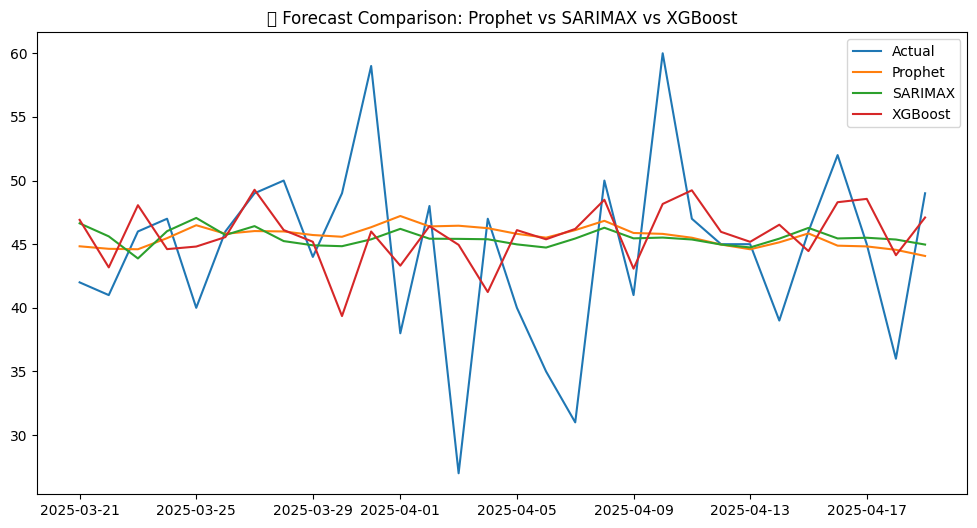

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(test_ts.index, actual, label='Actual')
plt.plot(test_ts.index, pred, label='Prophet')
plt.plot(test_ts.index, sarimax_forecast, label='SARIMAX')
plt.plot(test_ts.index, y_pred_xgb, label='XGBoost')
plt.title('📊 Forecast Comparison: Prophet vs SARIMAX vs XGBoost')
plt.legend()
plt.show()

In [31]:
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].to_csv("/content/drive/MyDrive/SwiftTraq/Portfolio/012_RV_Van_Rentals_Analytics/data/forecast_demand.csv", index=False)
print('✅ Saved forecast_demand data')

✅ Saved forecast_demand data
